In [1]:
"""

"""

import os
import shutil
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import kagglehub

class DataPreprocessor:
    @staticmethod
    def organize_data(source_path, target_path='/content/brain_tumor_split', test_size=0.2):
        """
        Split data into train and test sets.
        """
        all_images, all_labels = [], []

        for class_name in ['yes', 'no']:
            class_path = os.path.join(source_path, class_name)
            images = os.listdir(class_path)
            for image in images:
                all_images.append(os.path.join(class_path, image))
                all_labels.append(class_name)

        # Split test set
        X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=test_size, stratify=all_labels, random_state=42)

        splits = {
            'train': (X_train, y_train),
            'test': (X_test, y_test)
        }

        for split, (images, labels) in splits.items():
            for class_name in ['yes', 'no']:
                class_path = os.path.join(target_path, split, class_name)
                os.makedirs(class_path, exist_ok=True)

            for image, label in zip(images, labels):
                shutil.copy(image, os.path.join(target_path, split, label))

        return target_path

class DataLoaderHelper:
    """
    Helper class to load data using PyTorch DataLoader.
    """
    @staticmethod
    def load_data(data_dir, image_size=(224, 224), batch_size=16, num_workers=2):
        """
        Load data from the specified directory.
        """
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(image_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        }

        image_datasets = {
            x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
            for x in ['train', 'test']
        }

        dataloaders = {
            x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers)
            for x in ['train', 'test']
        }

        train_labels = [label for _, label in image_datasets['train']]
        class_counts = torch.bincount(torch.tensor(train_labels))
        class_weights = 1.0 / class_counts.float()
        class_weights = class_weights / class_weights.sum() * 2  # Normalize

        return dataloaders, class_weights, image_datasets

class DataUtils:
    @staticmethod
    def load_brain_tumor_data_pipeline(dataset_url='navoneel/brain-mri-images-for-brain-tumor-detection',
                                        target_path='/content/brain_tumor_data'):
        """
        Load brain tumor dataset from a URL and organize it into train/test splits.
        """
        # Download dataset
        path = kagglehub.dataset_download(dataset_url)

        # Organize data
        target_path = DataPreprocessor.organize_data(path, target_path)

        # Load data using DataLoader
        dataloaders, class_weights, image_datasets = DataLoaderHelper.load_data(target_path)

        return dataloaders, class_weights, image_datasets

if __name__ == "__main__":
    # Example usage
    dataloaders, class_weights, image_datasets = DataUtils.load_brain_tumor_data_pipeline(target_path='.data/brain_tumor_split')

In [2]:
"""
APPROACH 3: DATA-CENTRIC DEEP LEARNING WITH CLASS IMBALANCE HANDLING
Complete implementation for Google Colab

This script focuses EXCLUSIVELY on DATA-CENTRIC approaches (model innovation is handled by other approaches):
- Class imbalance strategies (Focal Loss, Class-Balanced Loss)
- Medical imaging-specific data augmentation techniques
- Weighted sampling strategies for balanced training
- Data-driven solutions for small medical imaging datasets

USAGE WITH EXTERNAL MODELS:
The Approach3Trainer and run_approach3_experiments functions support external model classes.
This allows the data-centric methods to be used with models from Approach 1 and Approach 2.

Example usage:
    # Using with external model class
    from approach1 import YourCustomCNN  # hypothetical import
    trainer = Approach3Trainer(config, model_class=YourCustomCNN)
    results = trainer.cross_validate(train_dataset, model_class=YourCustomCNN)

    # Or run experiments with external model
    all_results = run_approach3_experiments(train_dataset, model_class=YourCustomCNN)

Note: The external model class must be compatible with the config['model_params'] structure.
"""

# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from collections import defaultdict
import random
from PIL import Image
import pandas as pd

# ============================================================================
# SETUP ENVIRONMENT
# ============================================================================

def setup_environment():
    """Setup the environment for Google Colab"""
    print("Setting up environment...")

    # Check if running on Colab
    try:
        import google.colab
        IN_COLAB = True
        print("Running on Google Colab")
    except ImportError:
        IN_COLAB = False
        print("Running locally")

    # Install required packages if on Colab
    if IN_COLAB:
        print("Installing required packages...")
        os.system("pip install kagglehub")
        os.system("pip install scikit-learn")
        os.system("pip install seaborn")
        os.system("pip install pandas")

    # Check GPU availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# ============================================================================
# MEDICAL IMAGE AUGMENTATION
# ============================================================================

class MedicalImageAugmentation:
    """Medical imaging specific augmentation techniques"""

    @staticmethod
    def gaussian_noise(image, mean=0, std=0.1):
        """Add Gaussian noise to simulate imaging artifacts"""
        if isinstance(image, Image.Image):
            image = np.array(image)

        noise = np.random.normal(mean, std, image.shape)
        noisy_image = np.clip(image + noise * 255, 0, 255).astype(np.uint8)
        return Image.fromarray(noisy_image)

    @staticmethod
    def intensity_shift(image, shift_range=0.1):
        """Simulate intensity variations in MRI scans"""
        if isinstance(image, Image.Image):
            image = np.array(image)

        shift = np.random.uniform(-shift_range, shift_range)
        shifted = np.clip(image + shift * 255, 0, 255)
        return Image.fromarray(shifted.astype(np.uint8))

    @staticmethod
    def gamma_correction(image, gamma_range=(0.8, 1.2)):
        """Apply gamma correction for contrast variation"""
        gamma = np.random.uniform(gamma_range[0], gamma_range[1])
        if isinstance(image, Image.Image):
            image = np.array(image)

        corrected = np.power(image / 255.0, gamma) * 255
        return Image.fromarray(np.clip(corrected, 0, 255).astype(np.uint8))

class MedicalRandomTransform:
    """Custom transform for medical images with various augmentation techniques"""

    def __init__(self, p=0.5):
        self.p = p
        self.augmentation = MedicalImageAugmentation()

    def __call__(self, image):
        if random.random() < self.p:
            aug_type = random.choice(['noise', 'intensity', 'gamma'])

            if aug_type == 'noise':
                image = self.augmentation.gaussian_noise(image, std=0.05)
            elif aug_type == 'intensity':
                image = self.augmentation.intensity_shift(image, shift_range=0.1)
            elif aug_type == 'gamma':
                image = self.augmentation.gamma_correction(image)

        return image

class AdvancedMedicalAugmentation:
    """Advanced data augmentation pipeline for medical imaging"""

    def __init__(self, image_size=(224, 224), augmentation_level='medium'):
        self.image_size = image_size
        self.augmentation_level = augmentation_level

    def get_transforms(self, phase='train'):
        """Get appropriate transforms for training or validation"""

        if phase == 'train':
            if self.augmentation_level == 'light':
                return self._get_light_augmentation()
            elif self.augmentation_level == 'medium':
                return self._get_medium_augmentation()
            elif self.augmentation_level == 'heavy':
                return self._get_heavy_augmentation()
            else:
                return self._get_medium_augmentation()
        else:
            return self._get_validation_transforms()

    def _get_light_augmentation(self):
        """Light augmentation for sensitive medical data"""
        return transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.RandomRotation(degrees=5),
            MedicalRandomTransform(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _get_medium_augmentation(self):
        """Medium augmentation balancing performance and data preservation"""
        return transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1),
                shear=5
            ),
            transforms.ColorJitter(
                brightness=0.1,
                contrast=0.1,
                saturation=0.1,
                hue=0.05
            ),
            MedicalRandomTransform(p=0.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _get_heavy_augmentation(self):
        """Heavy augmentation for maximizing data diversity"""
        return transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.15, 0.15),
                scale=(0.8, 1.2),
                shear=10
            ),
            transforms.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.1
            ),
            transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
            MedicalRandomTransform(p=0.5),
            transforms.ToTensor(),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _get_validation_transforms(self):
        """Standard transforms for validation/testing"""
        return transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

# ============================================================================
# LOSS FUNCTIONS FOR CLASS IMBALANCE
# ============================================================================

class FocalLoss(nn.Module):
    """Focal Loss implementation for addressing class imbalance"""
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class ClassBalancedLoss(nn.Module):
    """Class-Balanced Loss for handling class imbalance"""
    def __init__(self, samples_per_class, beta=0.9999, gamma=2.0):
        super(ClassBalancedLoss, self).__init__()
        effective_num = 1.0 - torch.pow(beta, samples_per_class.float())
        weights = (1.0 - beta) / effective_num
        self.register_buffer('weights', weights / weights.sum() * len(weights))
        self.gamma = gamma

    def forward(self, inputs, targets):
        weights = self.weights[targets]
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = weights * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

# ============================================================================
# SIMPLE BASELINE MODEL FOR APPROACH 3
# ============================================================================
# NOTE: Approach 3 uses a simple baseline CNN to isolate data-centric improvements
# Model architecture innovation is handled by Approach 1 and Approach 2

class SimpleCNN(nn.Module):
    """Simple baseline CNN for Approach 3"""
    def __init__(self, dropout_rate=0.3):
        super(SimpleCNN, self).__init__()

        # Simple feature extraction
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
        )

        # Simple classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        features = self.features(x)
        output = self.classifier(features)
        return output

# ============================================================================
# CLASS IMBALANCE HANDLING
# ============================================================================

class ClassImbalanceHandler:
    """Comprehensive class imbalance handling strategies"""

    @staticmethod
    def calculate_class_weights(labels, method='inverse_freq'):
        """Calculate class weights for handling imbalance"""
        unique_labels, counts = torch.unique(torch.tensor(labels), return_counts=True)

        if method == 'inverse_freq':
            weights = 1.0 / counts.float()
        elif method == 'balanced':
            weights = len(labels) / (len(unique_labels) * counts.float())
        else:
            weights = torch.ones_like(counts).float()

        return weights

    @staticmethod
    def create_weighted_sampler(labels):
        """Create weighted random sampler for balanced batch sampling"""
        class_weights = ClassImbalanceHandler.calculate_class_weights(labels)
        sample_weights = [class_weights[label] for label in labels]
        return WeightedRandomSampler(sample_weights, len(sample_weights))

    @staticmethod
    def analyze_class_distribution(dataset):
        """Analyze and visualize class distribution"""
        labels = [dataset[i][1] for i in range(len(dataset))]
        unique_labels, counts = np.unique(labels, return_counts=True)

        print(f"Class distribution:")
        for label, count in zip(unique_labels, counts):
            print(f"  Class {label}: {count} samples ({count/len(labels)*100:.1f}%)")

        # Calculate imbalance ratio
        imbalance_ratio = max(counts) / min(counts)
        print(f"Imbalance ratio: {imbalance_ratio:.2f}")

        return labels, unique_labels, counts

# ============================================================================
# APPROACH 3 TRAINER CLASS
# ============================================================================

class Approach3Trainer:
    """Main trainer class for Approach 3 with comprehensive class imbalance handling"""

    def __init__(self, config, model_class=None):
        self.config = config
        self.model_class = model_class if model_class is not None else SimpleCNN
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.history = defaultdict(list)
        self.best_models = {}

        print(f"Using device: {self.device}")
        print(f"Using model: {self.model_class.__name__}")

    def create_fold_loaders(self, train_dataset, train_indices, val_indices, augmentation, use_weighted_sampling=True):
        """Create data loaders for a specific fold using existing dataset structure"""

        # Create custom datasets with proper transforms
        class TransformDataset:
            def __init__(self, base_dataset, indices, transform):
                self.base_dataset = base_dataset
                self.indices = indices
                self.transform = transform

            def __len__(self):
                return len(self.indices)

            def __getitem__(self, idx):
                real_idx = self.indices[idx]
                image_path, label = self.base_dataset.imgs[real_idx]
                image = Image.open(image_path).convert('RGB')

                if self.transform:
                    image = self.transform(image)

                return image, label

        # Create datasets with proper transforms
        train_fold_dataset = TransformDataset(train_dataset, train_indices, augmentation.get_transforms('train'))
        val_fold_dataset = TransformDataset(train_dataset, val_indices, augmentation.get_transforms('val'))

        # Training loader with augmentation
        if use_weighted_sampling:
            train_labels = [train_dataset.imgs[i][1] for i in train_indices]
            sampler = ClassImbalanceHandler.create_weighted_sampler(train_labels)
            train_loader = DataLoader(
                train_fold_dataset,
                batch_size=self.config.get('batch_size', 16),
                sampler=sampler,
                num_workers=0  # Set to 0 for Colab compatibility
            )
        else:
            train_loader = DataLoader(
                train_fold_dataset,
                batch_size=self.config.get('batch_size', 16),
                shuffle=True,
                num_workers=0  # Set to 0 for Colab compatibility
            )

        # Validation loader without augmentation
        val_loader = DataLoader(
            val_fold_dataset,
            batch_size=self.config.get('batch_size', 16),
            shuffle=False,
            num_workers=0  # Set to 0 for Colab compatibility
        )

        return train_loader, val_loader

    def train_epoch(self, model, loader, criterion, optimizer, scheduler=None):
        """Train for one epoch"""
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in loader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        if scheduler is not None:
            scheduler.step()

        epoch_loss = running_loss / len(loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc

    def validate_epoch(self, model, loader, criterion):
        """Validate for one epoch"""
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []
        all_probabilities = []

        with torch.no_grad():
            for inputs, targets in loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                running_loss += loss.item()

                # Get predictions and probabilities
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = outputs.max(1)

                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

        epoch_loss = running_loss / len(loader)
        epoch_acc = 100. * correct / total

        return epoch_loss, epoch_acc, all_predictions, all_targets, all_probabilities

    def train_fold(self, model, train_loader, val_loader, fold_num, loss_type='focal'):
        """Train a single fold"""
        print(f"\n--- Training Fold {fold_num + 1} ---")

        # Setup loss function based on fold
        train_labels = [train_loader.dataset.base_dataset.imgs[i][1] for i in train_loader.dataset.indices]

        if loss_type == 'focal':
            criterion = FocalLoss(alpha=1, gamma=2)
        elif loss_type == 'class_balanced':
            # Calculate samples per class for this fold
            _, counts = np.unique(train_labels, return_counts=True)
            samples_per_class = torch.tensor(counts)
            criterion = ClassBalancedLoss(samples_per_class=samples_per_class)
        else:
            criterion = nn.CrossEntropyLoss()

        criterion = criterion.to(self.device)

        # Setup optimizer and scheduler
        optimizer = optim.AdamW(
            model.parameters(),
            lr=self.config.get('learning_rate', 0.001),
            weight_decay=self.config.get('weight_decay', 0.01)
        )

        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.config.get('epochs', 50),
            eta_min=1e-6
        )

        # Training loop
        best_val_acc = 0.0
        best_model_weights = None
        patience_counter = 0
        patience = self.config.get('patience', 15)

        fold_history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }

        for epoch in range(self.config.get('epochs', 50)):
            start_time = time.time()

            # Training
            train_loss, train_acc = self.train_epoch(
                model, train_loader, criterion, optimizer, scheduler
            )

            # Validation
            val_loss, val_acc, val_preds, val_targets, val_probs = self.validate_epoch(
                model, val_loader, criterion
            )

            # Record history
            fold_history['train_loss'].append(train_loss)
            fold_history['train_acc'].append(train_acc)
            fold_history['val_loss'].append(val_loss)
            fold_history['val_acc'].append(val_acc)

            # Early stopping and best model saving
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_weights = copy.deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1

            epoch_time = time.time() - start_time
            print(f"Epoch {epoch+1:2d}/{self.config.get('epochs', 50)} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
                  f"Time: {epoch_time:.1f}s")

            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        # Load best model weights
        model.load_state_dict(best_model_weights)

        # Final validation with best model
        val_loss, val_acc, val_preds, val_targets, val_probs = self.validate_epoch(
            model, val_loader, criterion
        )

        return model, fold_history, val_acc, val_preds, val_targets, val_probs

    def cross_validate(self, train_dataset, n_splits=5, model_class=None):
        """Perform k-fold cross-validation"""
        print(f"Starting {n_splits}-fold cross-validation")

        # Use provided model_class or fall back to trainer's default
        if model_class is not None:
            self.model_class = model_class
            print(f"Using provided model: {self.model_class.__name__}")

        # Get labels and setup augmentation
        labels, _, _ = ClassImbalanceHandler.analyze_class_distribution(train_dataset)

        augmentation = AdvancedMedicalAugmentation(
            image_size=self.config.get('image_size', (224, 224)),
            augmentation_level=self.config.get('augmentation_level', 'medium')
        )

        # Setup cross-validation
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        fold_results = []
        all_predictions = []
        all_targets = []
        all_probabilities = []

        for fold, (train_indices, val_indices) in enumerate(skf.split(range(len(train_dataset)), labels)):
            print(f"\n{'='*50}")
            print(f"FOLD {fold + 1}/{n_splits}")
            print(f"{'='*50}")

            # Create fold-specific data loaders
            train_loader, val_loader = self.create_fold_loaders(
                train_dataset, train_indices, val_indices, augmentation,
                use_weighted_sampling=self.config.get('use_weighted_sampling', True)
            )

            # Initialize model for this fold
            model = self.model_class(**self.config.get('model_params', {})).to(self.device)

            # Train fold
            trained_model, fold_history, val_acc, val_preds, val_targets, val_probs = self.train_fold(
                model, train_loader, val_loader, fold,
                loss_type=self.config.get('loss_type', 'focal')
            )

            # Store results
            fold_results.append({
                'fold': fold + 1,
                'val_accuracy': val_acc,
                'history': fold_history,
                'model': trained_model
            })

            all_predictions.extend(val_preds)
            all_targets.extend(val_targets)
            all_probabilities.extend(val_probs)

            # Calculate fold metrics
            fold_auc = roc_auc_score(val_targets, np.array(val_probs)[:, 1])
            print(f"Fold {fold + 1} Results:")
            print(f"  Validation Accuracy: {val_acc:.2f}%")
            print(f"  Validation AUC: {fold_auc:.4f}")

            # Store best model for this fold
            self.best_models[f'fold_{fold + 1}'] = copy.deepcopy(trained_model.state_dict())

        # Calculate overall metrics
        self.calculate_final_metrics(fold_results, all_predictions, all_targets, all_probabilities)

        return fold_results, all_predictions, all_targets, all_probabilities

    def calculate_final_metrics(self, fold_results, all_predictions, all_targets, all_probabilities):
        """Calculate and display final cross-validation metrics"""
        print(f"\n{'='*60}")
        print("CROSS-VALIDATION RESULTS")
        print(f"{'='*60}")

        # Individual fold results
        val_accuracies = [result['val_accuracy'] for result in fold_results]
        print("Fold Results:")
        for i, acc in enumerate(val_accuracies):
            print(f"  Fold {i+1}: {acc:.2f}%")

        # Summary statistics
        mean_acc = np.mean(val_accuracies)
        std_acc = np.std(val_accuracies)
        print(f"\nCross-Validation Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")

        # Overall metrics using all predictions
        overall_auc = roc_auc_score(all_targets, np.array(all_probabilities)[:, 1])
        print(f"Overall AUC: {overall_auc:.4f}")

        # Classification report
        print(f"\nOverall Classification Report:")
        print(classification_report(all_targets, all_predictions))

        # Confusion matrix
        cm = confusion_matrix(all_targets, all_predictions)
        print(f"\nOverall Confusion Matrix:")
        print(cm)

        # Store results
        self.history['cv_accuracies'] = val_accuracies
        self.history['mean_accuracy'] = mean_acc
        self.history['std_accuracy'] = std_acc
        self.history['overall_auc'] = overall_auc

# ============================================================================
# MAIN EXECUTION FOR APPROACH 3
# ============================================================================

def create_approach3_config():
    """Create default configuration for Approach 3"""
    return {
        'model_params': {
            'dropout_rate': 0.3
        },
        'loss_type': 'focal',  # 'focal', 'class_balanced'
        'image_size': (224, 224),
        'batch_size': 16,
        'learning_rate': 0.001,
        'weight_decay': 0.01,
        'epochs': 25,
        'patience': 10,
        'use_weighted_sampling': True,
        'augmentation_level': 'medium'
    }

def run_approach3_experiments(train_dataset, model_class=None):
    """Run Approach 3 experiments with different data-centric class imbalance strategies"""
    print("\n" + "="*60)
    print("RUNNING APPROACH 3 EXPERIMENTS")
    print("Data-Centric Deep Learning with Class Imbalance Handling")
    print("="*60)

    # Use SimpleCNN as default if no model_class provided
    if model_class is None:
        model_class = SimpleCNN
        print("Using default SimpleCNN model for Approach 3 experiments")
    else:
        print(f"Using provided model: {model_class.__name__}")

    # Define Approach 3 experimental configurations
    experiments = {
        'focal_loss_light_aug': {
            'description': 'Data Strategy: Focal Loss + Light Medical Augmentation',
            'config': {
                'loss_type': 'focal',
                'augmentation_level': 'light',
                'use_weighted_sampling': False,
                'epochs': 20
            }
        },
        'focal_loss_heavy_aug': {
            'description': 'Data Strategy: Focal Loss + Heavy Medical Augmentation',
            'config': {
                'loss_type': 'focal',
                'augmentation_level': 'heavy',
                'use_weighted_sampling': True,
                'epochs': 20
            }
        },
        'class_balanced_weighted_sampling': {
            'description': 'Data Strategy: Class-Balanced Loss + Weighted Sampling',
            'config': {
                'loss_type': 'class_balanced',
                'augmentation_level': 'medium',
                'use_weighted_sampling': True,
                'epochs': 20
            }
        }
    }

    all_results = {}

    for exp_name, exp_config in experiments.items():
        print(f"\n{'='*50}")
        print(f"EXPERIMENT: {exp_config['description']}")
        print(f"{'='*50}")

        # Create configuration
        config = create_approach3_config()
        config.update(exp_config['config'])

        # Initialize trainer
        trainer = Approach3Trainer(config, model_class=model_class)

        try:
            # Run cross-validation
            fold_results, all_predictions, all_targets, all_probabilities = trainer.cross_validate(
                train_dataset, n_splits=3
            )

            # Store results
            all_results[exp_name] = {
                'description': exp_config['description'],
                'config': config,
                'fold_results': fold_results,
                'predictions': all_predictions,
                'targets': all_targets,
                'probabilities': all_probabilities,
                'mean_accuracy': trainer.history['mean_accuracy'],
                'std_accuracy': trainer.history['std_accuracy'],
                'overall_auc': trainer.history['overall_auc']
            }

        except Exception as e:
            print(f"Error in experiment {exp_name}: {e}")
            continue

    return all_results

def compare_approach3_results(all_results):
    """Compare results from different Approach 3 experiments"""
    print("\n" + "="*60)
    print("APPROACH 3 EXPERIMENT COMPARISON")
    print("="*60)

    if not all_results:
        print("No results to compare")
        return

    # Create comparison table
    comparison_data = []
    for _, results in all_results.items():
        comparison_data.append({
            'Experiment': results['description'],
            'Mean Accuracy': f"{results['mean_accuracy']:.2f}%",
            'Std Accuracy': f"{results['std_accuracy']:.2f}%",
            'AUC': f"{results['overall_auc']:.4f}",
            'Loss Type': results['config']['loss_type'],
            'Augmentation': results['config']['augmentation_level'],
            'Weighted Sampling': results['config']['use_weighted_sampling']
        })

    # Print comparison table
    df = pd.DataFrame(comparison_data)
    print(df.to_string(index=False))

    # Visualize comparison
    _, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy comparison
    exp_names = [results['description'] for results in all_results.values()]
    accuracies = [results['mean_accuracy'] for results in all_results.values()]
    std_devs = [results['std_accuracy'] for results in all_results.values()]

    bars1 = axes[0].bar(range(len(exp_names)), accuracies, yerr=std_devs, capsize=5,
                       color=['lightblue', 'lightgreen', 'lightcoral'])
    axes[0].set_xlabel('Data-Centric Strategy')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_title('Approach 3: Data-Centric Accuracy Comparison')
    axes[0].set_xticks(range(len(exp_names)))
    axes[0].set_xticklabels([name.split(' ')[0] + '\n' + name.split(' ')[1] for name in exp_names], rotation=45)

    # Add value labels on bars
    for bar, acc in zip(bars1, accuracies):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{acc:.1f}%', ha='center', va='bottom')

    # AUC comparison
    aucs = [results['overall_auc'] for results in all_results.values()]
    bars2 = axes[1].bar(range(len(exp_names)), aucs,
                       color=['lightblue', 'lightgreen', 'lightcoral'])
    axes[1].set_xlabel('Data-Centric Strategy')
    axes[1].set_ylabel('AUC')
    axes[1].set_title('Approach 3: Data-Centric AUC Comparison')
    axes[1].set_xticks(range(len(exp_names)))
    axes[1].set_xticklabels([name.split(' ')[0] + '\n' + name.split(' ')[1] for name in exp_names], rotation=45)

    # Add value labels on bars
    for bar, auc in zip(bars2, aucs):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{auc:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Find best performing experiment
    best_exp = max(all_results.items(), key=lambda x: x[1]['mean_accuracy'])
    print(f"\nBest performing Approach 3 experiment: {best_exp[1]['description']}")
    print(f"Accuracy: {best_exp[1]['mean_accuracy']:.2f}% ± {best_exp[1]['std_accuracy']:.2f}%")
    print(f"AUC: {best_exp[1]['overall_auc']:.4f}")

def visualize_class_distribution(dataset):
    """Visualize class distribution"""
    _, _, counts = ClassImbalanceHandler.analyze_class_distribution(dataset)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(dataset.classes, counts, color=['lightcoral', 'lightblue'])
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    for i, count in enumerate(counts):
        plt.text(i, count + 1, str(count), ha='center', va='bottom')

    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=dataset.classes, autopct='%1.1f%%',
            colors=['lightcoral', 'lightblue'])
    plt.title('Class Distribution (Percentage)')

    plt.tight_layout()
    plt.show()

def main():
    """Main execution function for Approach 3"""
    print("APPROACH 3: DATA-CENTRIC DEEP LEARNING WITH CLASS IMBALANCE HANDLING")
    print("=" * 80)
    print("Brain Tumor Detection using Advanced Class Imbalance Strategies")
    print("=" * 80)

    # Setup environment
    setup_environment()

    # Load and analyze data using data_utils.py methods
    print("\nLoading brain tumor dataset using data_utils.py...")
    try:
        _, _, image_datasets = DataUtils.load_brain_tumor_data_pipeline(target_path='.data/brain_tumor_split')

        train_dataset = image_datasets['train']
        print(f"Successfully loaded dataset with {len(train_dataset)} training samples")
        print(f"Classes: {train_dataset.classes}")

        # Visualize class distribution
        visualize_class_distribution(train_dataset)

    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    # Run Approach 3 experiments
    print("\nStarting Approach 3 experiments...")
    all_results = run_approach3_experiments(train_dataset)

    # Compare experiments
    if all_results:
        compare_approach3_results(all_results)

        print("\n" + "="*80)
        print("APPROACH 3 COMPLETED SUCCESSFULLY!")
        print("="*80)
        print("\nKey Approach 3 Findings (Data-Centric Deep Learning):")
        print("1. Implemented and compared multiple class imbalance handling strategies")
        print("2. Evaluated Focal Loss vs Class-Balanced Loss effectiveness for medical data")
        print("3. Applied medical imaging-specific data augmentation techniques")
        print("4. Compared different augmentation levels (light/medium/heavy) impact")
        print("5. Analyzed weighted sampling strategies for class imbalance")
        print("6. Conducted comprehensive cross-validation with stratified splitting")
        print("7. Used simple baseline CNN to isolate data-centric improvements")
        print("8. Demonstrated data techniques work independently of model complexity")

        # Print summary of best results
        if all_results:
            best_exp = max(all_results.items(), key=lambda x: x[1]['mean_accuracy'])
            print(f"\nBest Approach 3 strategy: {best_exp[1]['description']}")
            print(f"Final accuracy: {best_exp[1]['mean_accuracy']:.2f}% ± {best_exp[1]['std_accuracy']:.2f}%")
            print(f"Final AUC: {best_exp[1]['overall_auc']:.4f}")
    else:
        print("No experiments completed successfully.")

# ============================================================================
# CONVENIENCE FUNCTIONS FOR EXTERNAL MODEL TESTING
# ============================================================================

def test_model_with_approach3_methods(model_class, train_dataset, config=None):
    """
    Convenience function to test an external model using Approach 3's data-centric methods

    Args:
        model_class: The model class to test (should be compatible with config['model_params'])
        train_dataset: The training dataset
        config: Optional configuration dict. If None, uses default config.

    Returns:
        Dictionary containing cross-validation results
    """
    print(f"\nTesting model {model_class.__name__} with Approach 3 data-centric methods")
    print("="*60)

    # Use default config if none provided
    if config is None:
        config = create_approach3_config()
        print("Using default Approach 3 configuration")

    # Initialize trainer with provided model
    trainer = Approach3Trainer(config, model_class=model_class)

    # Run cross-validation
    fold_results, all_predictions, all_targets, all_probabilities = trainer.cross_validate(
        train_dataset, n_splits=3
    )

    # Return results in a structured format
    return {
        'model_name': model_class.__name__,
        'fold_results': fold_results,
        'mean_accuracy': trainer.history['mean_accuracy'],
        'std_accuracy': trainer.history['std_accuracy'],
        'overall_auc': trainer.history['overall_auc'],
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probabilities
    }

def compare_models_with_approach3(model_classes, train_dataset, config=None):
    """
    Compare multiple model classes using Approach 3's data-centric methods

    Args:
        model_classes: List of model classes to compare
        train_dataset: The training dataset
        config: Optional configuration dict. If None, uses default config.

    Returns:
        Dictionary containing results for all models
    """
    print(f"\nComparing {len(model_classes)} models with Approach 3 data-centric methods")
    print("="*70)

    all_results = {}

    for model_class in model_classes:
        try:
            results = test_model_with_approach3_methods(model_class, train_dataset, config)
            all_results[model_class.__name__] = results
        except Exception as e:
            print(f"Error testing {model_class.__name__}: {e}")
            continue

    # Create comparison summary
    if all_results:
        print(f"\n{'='*70}")
        print("MODEL COMPARISON SUMMARY")
        print(f"{'='*70}")

        comparison_data = []
        for model_name, results in all_results.items():
            comparison_data.append({
                'Model': model_name,
                'Mean Accuracy': f"{results['mean_accuracy']:.2f}%",
                'Std Accuracy': f"{results['std_accuracy']:.2f}%",
                'AUC': f"{results['overall_auc']:.4f}"
            })

        df = pd.DataFrame(comparison_data)
        print(df.to_string(index=False))

        # Find best model
        best_model = max(all_results.items(), key=lambda x: x[1]['mean_accuracy'])
        print(f"\nBest performing model: {best_model[0]}")
        print(f"Accuracy: {best_model[1]['mean_accuracy']:.2f}% ± {best_model[1]['std_accuracy']:.2f}%")
        print(f"AUC: {best_model[1]['overall_auc']:.4f}")

    return all_results


In [3]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


def evaluate_model(y_true, y_pred, y_probs, model_name, dir=None):
    """
    Evaluate the model performance using various metrics.

    Args:
        y_true: True labels
        y_pred: Predicted labels
        y_probs: Prediction probabilities
        model_name: Name of the model
        dir: Directory to save results (optional, defaults to timestamped folder)
    """
    all_labels = y_true
    all_preds = y_pred
    all_probs = y_probs

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs[:, 1])

    print("\nEvaluation metrics:")
    print(f"\nAccuracy: {accuracy :.2%}")
    print(f"Precision: {precision: .2%}")
    print(f"Recall: {recall: .2%}")
    print(f"F1 Score: {f1: .2%}")
    print(f"AUC Score: {auc: .4f}")

    # Create visualizations
    if dir is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        evaluation_dir = os.path.join("results", "figures", f"{model_name}_{timestamp}")
    else:
        evaluation_dir = os.path.join(dir, model_name)

    os.makedirs(evaluation_dir, exist_ok=True)

    # Draw confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Tumor', 'Tumor'],
                yticklabels=['No Tumor', 'Tumor'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    cm_filename = f"confusion_matrix.png"
    cm_filepath = os.path.join(evaluation_dir, cm_filename)
    plt.savefig(cm_filepath, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrix saved to: {cm_filepath}")

    # Draw ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    roc_filename = f"roc_curve.png"
    roc_filepath = os.path.join(evaluation_dir, roc_filename)
    plt.savefig(roc_filepath, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"ROC curve saved to: {roc_filepath}")

    # Save input data to file in the same evaluation directory
    input_data = {
        "y_true": np.array(y_true).tolist(),
        "y_pred": np.array(y_pred).tolist(),
        "y_probs": np.array(y_probs).tolist()
    }

    filename = f"input_data.json"
    filepath = os.path.join(evaluation_dir, filename)

    with open(filepath, 'w') as f:
        json.dump(input_data, f, indent=2)

    print(f"\nInput data saved to: {filepath}")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auc": auc
    }



In [4]:
import torch.nn as nn

class CustomCNN_Approach1(nn.Module):
    """
    Custom CNN model for brain tumor detection (Approach 1)
    Compatible with Approach 3 data-centric methods
    """
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.dropout_rate = dropout_rate

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout2d(dropout_rate * 0.5),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout2d(dropout_rate * 0.7),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout2d(dropout_rate),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout2d(dropout_rate),

            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [5]:
import torch.nn as nn
from torchvision import models

class EfficientNetB0_FeatureExtraction(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super().__init__()
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        for param in model.parameters():
            param.requires_grad = False
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2),
        )
        self.model = model

    def forward(self, x):
        return self.model(x)

class EfficientNetB0_FineTuning(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super().__init__()
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2),
        )
        self.model = model

    def forward(self, x):
        return self.model(x)

class ResNet50_FeatureExtraction(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super().__init__()
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        for param in model.parameters():
            param.requires_grad = False
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2),
        )
        self.model = model

    def forward(self, x):
        return self.model(x)

class ResNet50_FineTuning(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super().__init__()
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2),
        )
        self.model = model

    def forward(self, x):
        return self.model(x)

class VGG16_FeatureExtraction(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super().__init__()
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        for param in model.parameters():
            param.requires_grad = False
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2),
        )
        self.model = model

    def forward(self, x):
        return self.model(x)

class VGG16_FineTuning(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super().__init__()
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2),
        )
        self.model = model

    def forward(self, x):
        return self.model(x)


==== Training VGG16_FeatureExtraction on original data ====


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 174MB/s]



Confusion Matrix:
[[17  3]
 [ 7 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.85      0.77        20
           1       0.89      0.77      0.83        31

    accuracy                           0.80        51
   macro avg       0.80      0.81      0.80        51
weighted avg       0.82      0.80      0.81        51


Evaluation metrics:

Accuracy: 80.39%
Precision:  88.89%
Recall:  77.42%
F1 Score:  82.76%
AUC Score:  0.8710


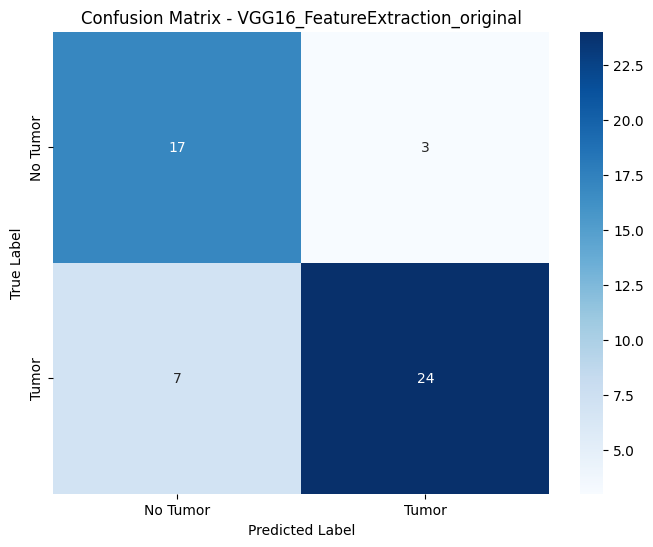

Confusion matrix saved to: results/figures/VGG16_FeatureExtraction_original_20250722_012457/confusion_matrix.png


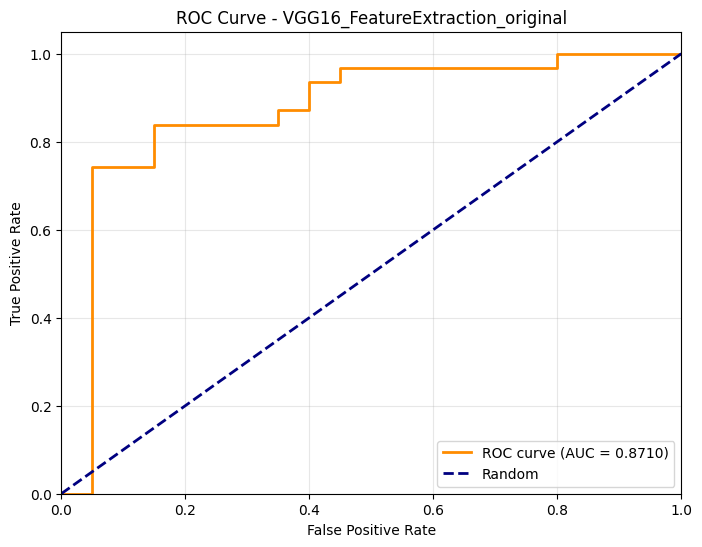

ROC curve saved to: results/figures/VGG16_FeatureExtraction_original_20250722_012457/roc_curve.png

Input data saved to: results/figures/VGG16_FeatureExtraction_original_20250722_012457/input_data.json

==== Training VGG16_FineTuning on original data ====

Confusion Matrix:
[[ 1 19]
 [ 0 31]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        20
           1       0.62      1.00      0.77        31

    accuracy                           0.63        51
   macro avg       0.81      0.53      0.43        51
weighted avg       0.77      0.63      0.50        51


Evaluation metrics:

Accuracy: 62.75%
Precision:  62.00%
Recall:  100.00%
F1 Score:  76.54%
AUC Score:  0.7758


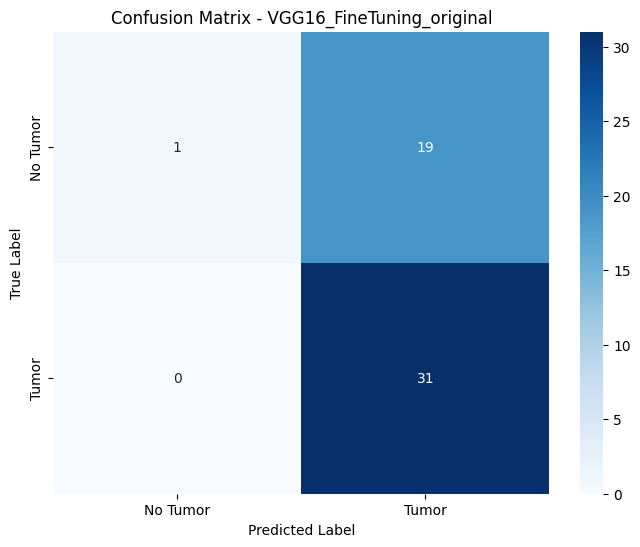

Confusion matrix saved to: results/figures/VGG16_FineTuning_original_20250722_012622/confusion_matrix.png


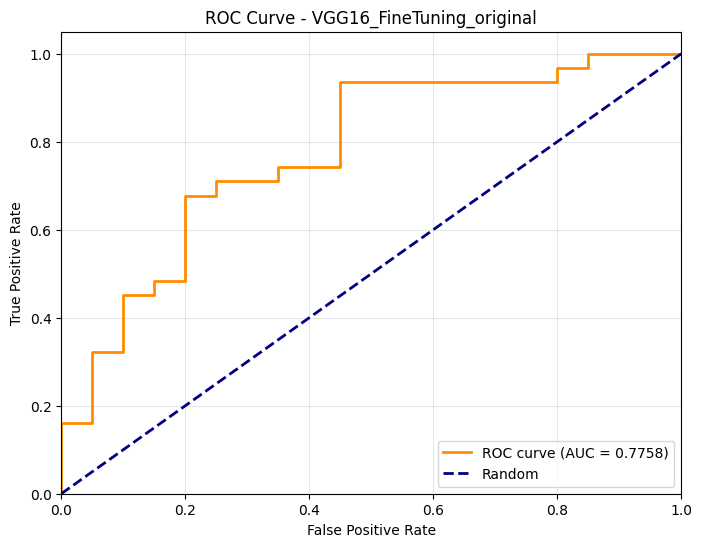

ROC curve saved to: results/figures/VGG16_FineTuning_original_20250722_012622/roc_curve.png

Input data saved to: results/figures/VGG16_FineTuning_original_20250722_012622/input_data.json

==== Training ResNet50_FeatureExtraction on original data ====


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]



Confusion Matrix:
[[16  4]
 [ 1 30]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86        20
           1       0.88      0.97      0.92        31

    accuracy                           0.90        51
   macro avg       0.91      0.88      0.89        51
weighted avg       0.91      0.90      0.90        51


Evaluation metrics:

Accuracy: 90.20%
Precision:  88.24%
Recall:  96.77%
F1 Score:  92.31%
AUC Score:  0.9121


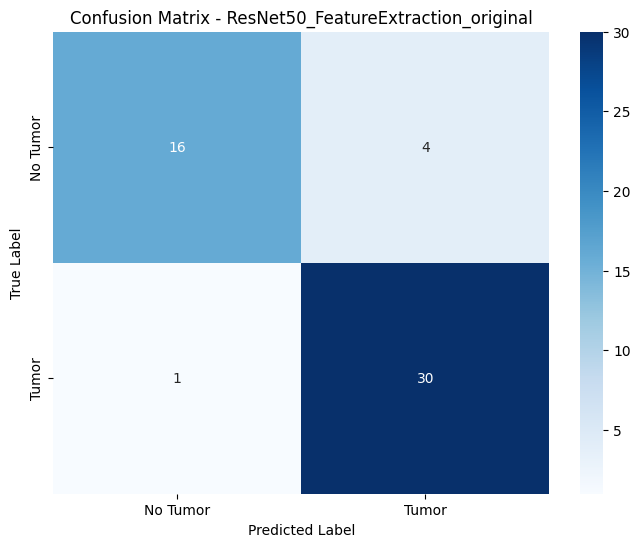

Confusion matrix saved to: results/figures/ResNet50_FeatureExtraction_original_20250722_012652/confusion_matrix.png


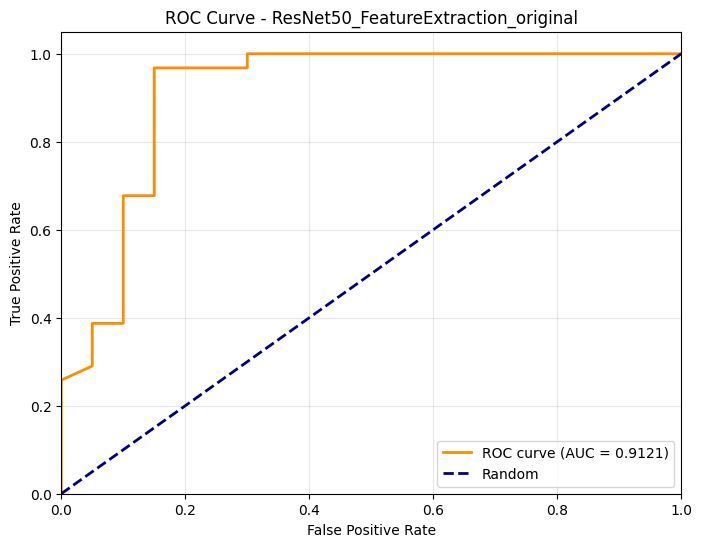

ROC curve saved to: results/figures/ResNet50_FeatureExtraction_original_20250722_012652/roc_curve.png

Input data saved to: results/figures/ResNet50_FeatureExtraction_original_20250722_012652/input_data.json

==== Training ResNet50_FineTuning on original data ====

Confusion Matrix:
[[18  2]
 [ 6 25]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        20
           1       0.93      0.81      0.86        31

    accuracy                           0.84        51
   macro avg       0.84      0.85      0.84        51
weighted avg       0.86      0.84      0.84        51


Evaluation metrics:

Accuracy: 84.31%
Precision:  92.59%
Recall:  80.65%
F1 Score:  86.21%
AUC Score:  0.9113


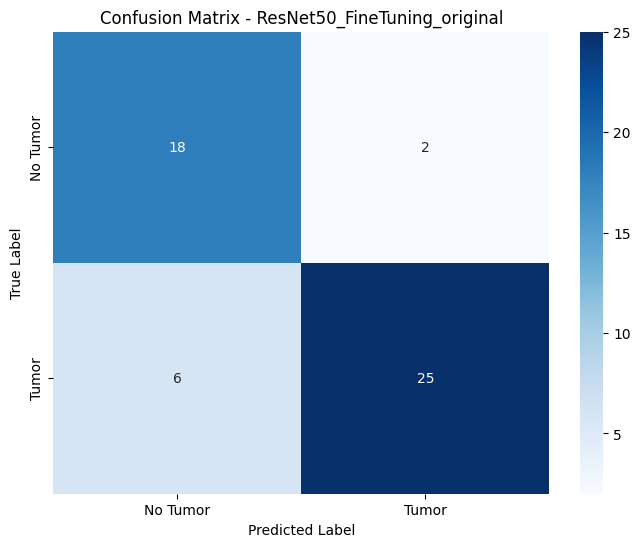

Confusion matrix saved to: results/figures/ResNet50_FineTuning_original_20250722_012751/confusion_matrix.png


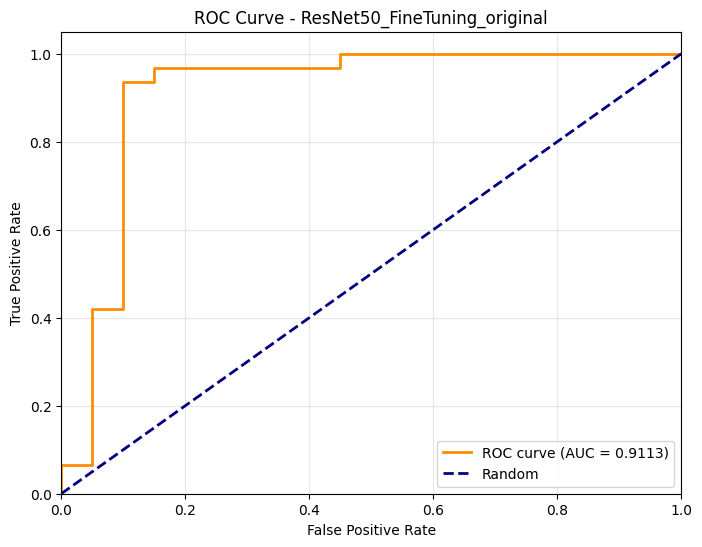

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


ROC curve saved to: results/figures/ResNet50_FineTuning_original_20250722_012751/roc_curve.png

Input data saved to: results/figures/ResNet50_FineTuning_original_20250722_012751/input_data.json

==== Training EfficientNetB0_FeatureExtraction on original data ====


100%|██████████| 20.5M/20.5M [00:00<00:00, 194MB/s]



Confusion Matrix:
[[14  6]
 [ 2 29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        20
           1       0.83      0.94      0.88        31

    accuracy                           0.84        51
   macro avg       0.85      0.82      0.83        51
weighted avg       0.85      0.84      0.84        51


Evaluation metrics:

Accuracy: 84.31%
Precision:  82.86%
Recall:  93.55%
F1 Score:  87.88%
AUC Score:  0.9210


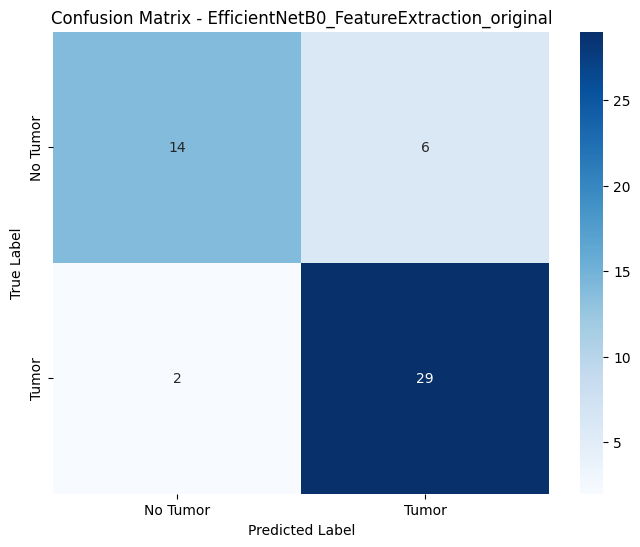

Confusion matrix saved to: results/figures/EfficientNetB0_FeatureExtraction_original_20250722_012818/confusion_matrix.png


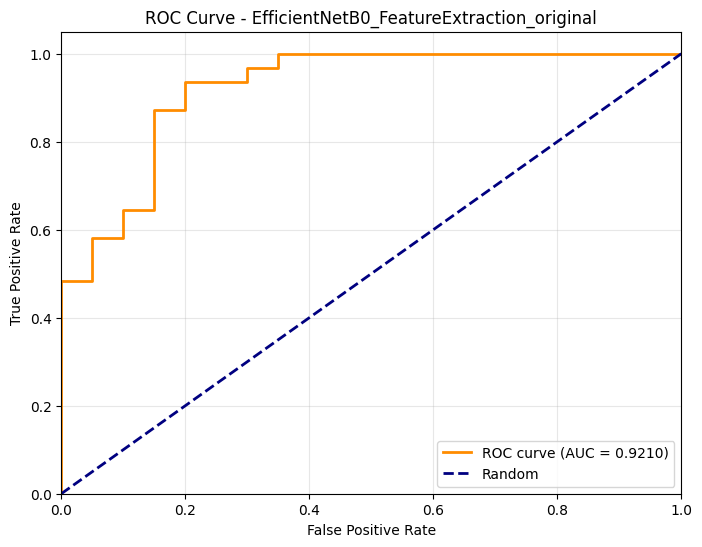

ROC curve saved to: results/figures/EfficientNetB0_FeatureExtraction_original_20250722_012818/roc_curve.png

Input data saved to: results/figures/EfficientNetB0_FeatureExtraction_original_20250722_012818/input_data.json

==== Training EfficientNetB0_FineTuning on original data ====

Confusion Matrix:
[[19  1]
 [ 3 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.97      0.90      0.93        31

    accuracy                           0.92        51
   macro avg       0.91      0.93      0.92        51
weighted avg       0.93      0.92      0.92        51


Evaluation metrics:

Accuracy: 92.16%
Precision:  96.55%
Recall:  90.32%
F1 Score:  93.33%
AUC Score:  0.9887


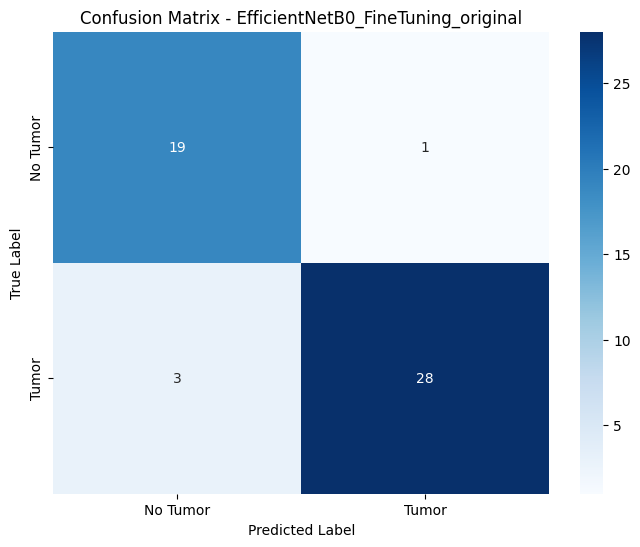

Confusion matrix saved to: results/figures/EfficientNetB0_FineTuning_original_20250722_012856/confusion_matrix.png


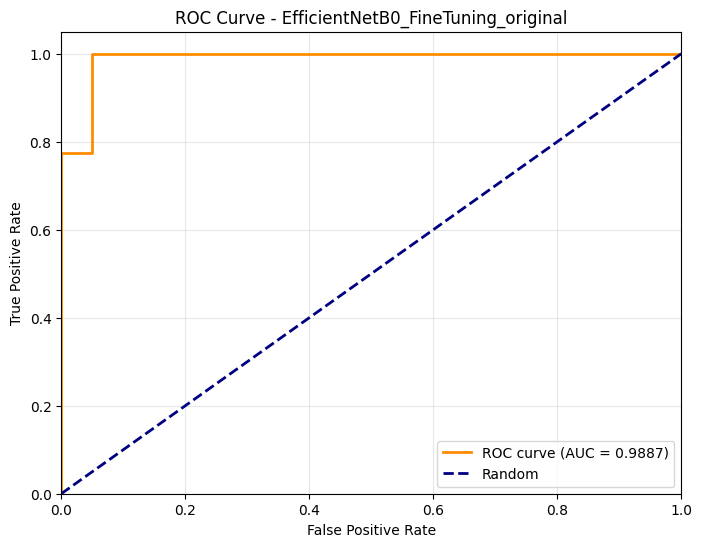

ROC curve saved to: results/figures/EfficientNetB0_FineTuning_original_20250722_012856/roc_curve.png

Input data saved to: results/figures/EfficientNetB0_FineTuning_original_20250722_012856/input_data.json

==== Training CustomCNN_Approach1 on original data ====

Confusion Matrix:
[[ 9 11]
 [ 1 30]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.45      0.60        20
           1       0.73      0.97      0.83        31

    accuracy                           0.76        51
   macro avg       0.82      0.71      0.72        51
weighted avg       0.80      0.76      0.74        51


Evaluation metrics:

Accuracy: 76.47%
Precision:  73.17%
Recall:  96.77%
F1 Score:  83.33%
AUC Score:  0.8726


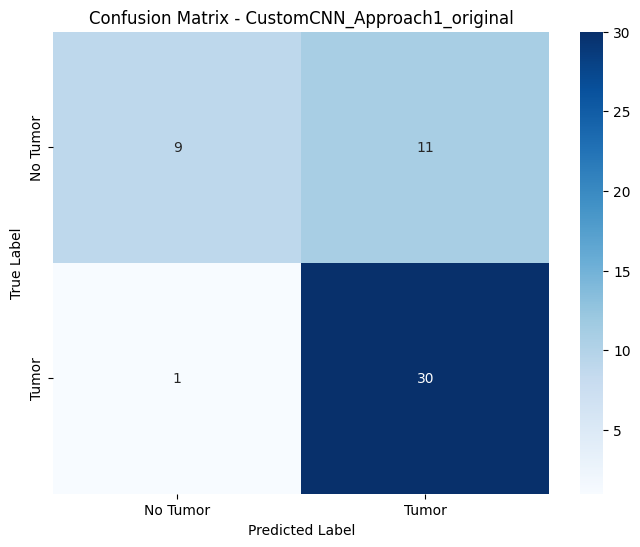

Confusion matrix saved to: results/figures/CustomCNN_Approach1_original_20250722_012930/confusion_matrix.png


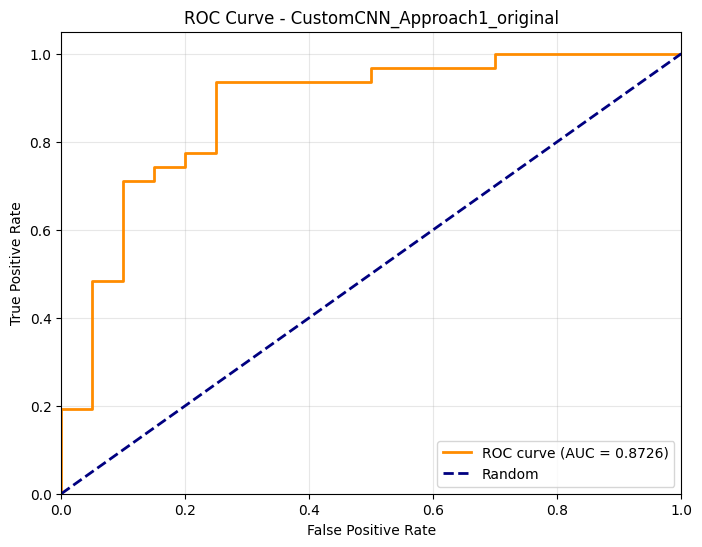

ROC curve saved to: results/figures/CustomCNN_Approach1_original_20250722_012930/roc_curve.png

Input data saved to: results/figures/CustomCNN_Approach1_original_20250722_012930/input_data.json

==== Training VGG16_FeatureExtraction with Approach 3 data-centric methods ====

Testing model VGG16_FeatureExtraction with Approach 3 data-centric methods
Using device: cuda
Using model: VGG16_FeatureExtraction
Starting 3-fold cross-validation
Class distribution:
  Class 0: 78 samples (38.6%)
  Class 1: 124 samples (61.4%)
Imbalance ratio: 1.59

FOLD 1/3

--- Training Fold 1 ---
Epoch  1/25 | Train Loss: 0.2316 | Train Acc: 55.22% | Val Loss: 0.4782 | Val Acc: 38.24% | Time: 2.5s
Epoch  2/25 | Train Loss: 0.1557 | Train Acc: 76.12% | Val Loss: 0.1869 | Val Acc: 63.24% | Time: 2.1s
Epoch  3/25 | Train Loss: 0.1439 | Train Acc: 70.90% | Val Loss: 0.1407 | Val Acc: 70.59% | Time: 2.2s
Epoch  4/25 | Train Loss: 0.1329 | Train Acc: 82.09% | Val Loss: 0.1034 | Val Acc: 76.47% | Time: 2.4s
Epoch  5/2

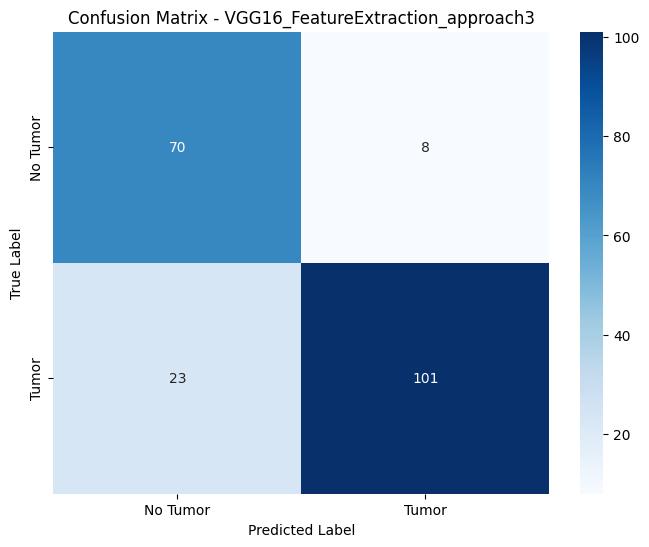

Confusion matrix saved to: results/figures/VGG16_FeatureExtraction_approach3_20250722_013203/confusion_matrix.png


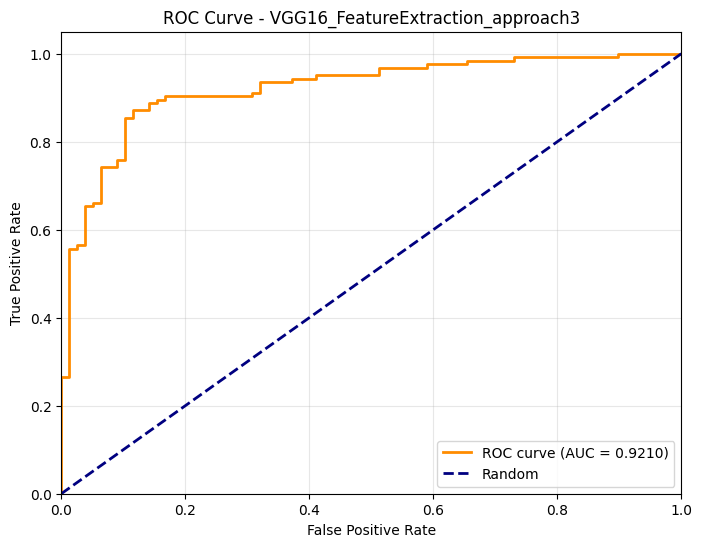

ROC curve saved to: results/figures/VGG16_FeatureExtraction_approach3_20250722_013203/roc_curve.png

Input data saved to: results/figures/VGG16_FeatureExtraction_approach3_20250722_013203/input_data.json

==== Training VGG16_FineTuning with Approach 3 data-centric methods ====

Testing model VGG16_FineTuning with Approach 3 data-centric methods
Using device: cuda
Using model: VGG16_FineTuning
Starting 3-fold cross-validation
Class distribution:
  Class 0: 78 samples (38.6%)
  Class 1: 124 samples (61.4%)
Imbalance ratio: 1.59

FOLD 1/3

--- Training Fold 1 ---
Epoch  1/25 | Train Loss: 1.0539 | Train Acc: 52.99% | Val Loss: 0.1869 | Val Acc: 38.24% | Time: 4.1s
Epoch  2/25 | Train Loss: 0.1822 | Train Acc: 46.27% | Val Loss: 0.1904 | Val Acc: 38.24% | Time: 3.7s
Epoch  3/25 | Train Loss: 0.1863 | Train Acc: 51.49% | Val Loss: 0.1794 | Val Acc: 38.24% | Time: 3.8s
Epoch  4/25 | Train Loss: 0.1748 | Train Acc: 50.75% | Val Loss: 0.1615 | Val Acc: 61.76% | Time: 4.2s
Epoch  5/25 | Train L

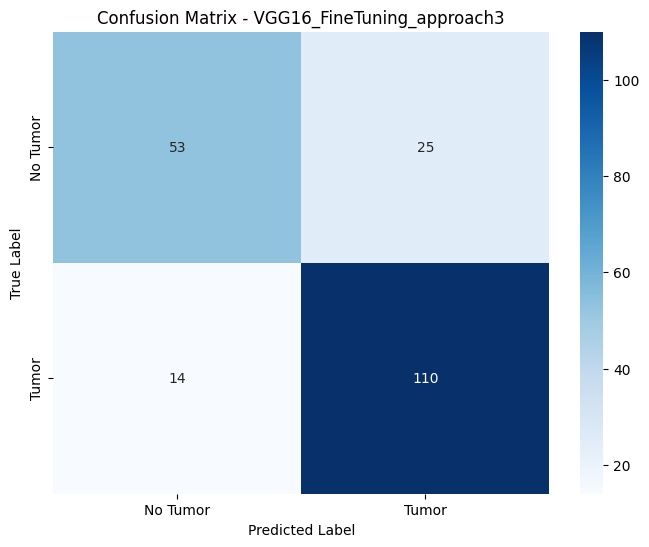

Confusion matrix saved to: results/figures/VGG16_FineTuning_approach3_20250722_013610/confusion_matrix.png


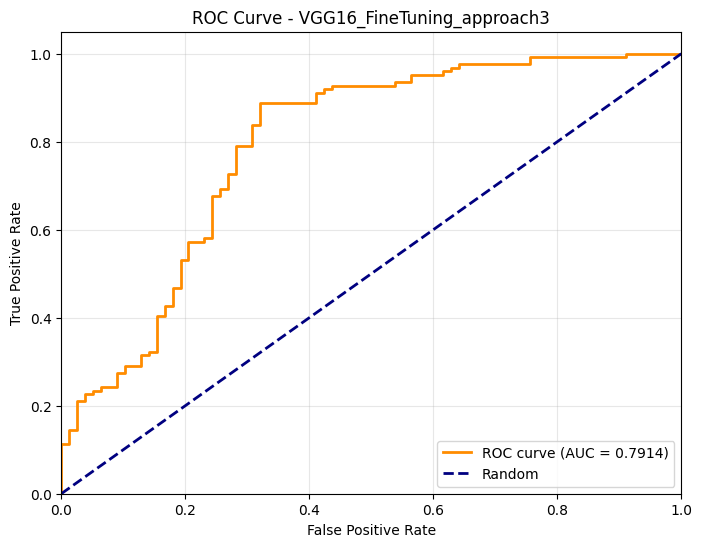

ROC curve saved to: results/figures/VGG16_FineTuning_approach3_20250722_013610/roc_curve.png

Input data saved to: results/figures/VGG16_FineTuning_approach3_20250722_013610/input_data.json

==== Training ResNet50_FeatureExtraction with Approach 3 data-centric methods ====

Testing model ResNet50_FeatureExtraction with Approach 3 data-centric methods
Using device: cuda
Using model: ResNet50_FeatureExtraction
Starting 3-fold cross-validation
Class distribution:
  Class 0: 78 samples (38.6%)
  Class 1: 124 samples (61.4%)
Imbalance ratio: 1.59

FOLD 1/3

--- Training Fold 1 ---
Epoch  1/25 | Train Loss: 0.1608 | Train Acc: 63.43% | Val Loss: 0.1881 | Val Acc: 63.24% | Time: 2.1s
Epoch  2/25 | Train Loss: 0.1287 | Train Acc: 70.90% | Val Loss: 0.4371 | Val Acc: 39.71% | Time: 1.9s
Epoch  3/25 | Train Loss: 0.0945 | Train Acc: 84.33% | Val Loss: 0.1161 | Val Acc: 77.94% | Time: 1.9s
Epoch  4/25 | Train Loss: 0.1647 | Train Acc: 76.12% | Val Loss: 0.4955 | Val Acc: 41.18% | Time: 1.8s
Epoch

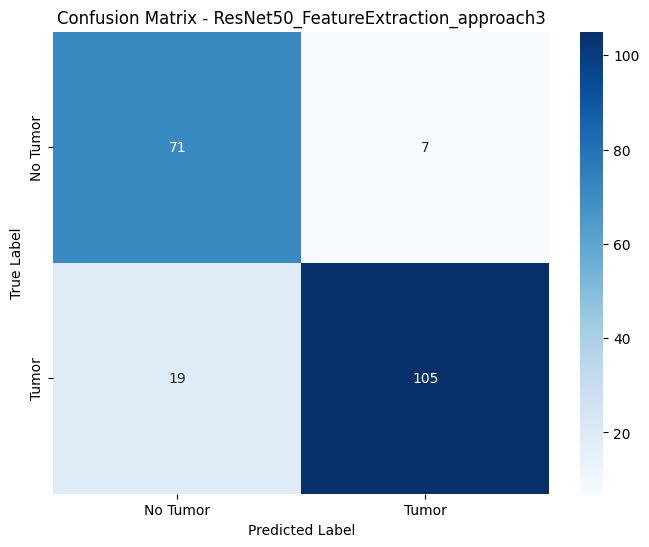

Confusion matrix saved to: results/figures/ResNet50_FeatureExtraction_approach3_20250722_013804/confusion_matrix.png


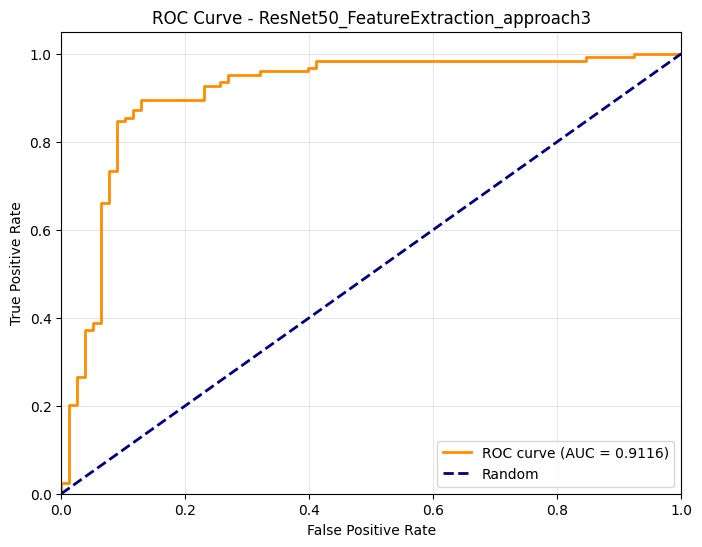

ROC curve saved to: results/figures/ResNet50_FeatureExtraction_approach3_20250722_013804/roc_curve.png

Input data saved to: results/figures/ResNet50_FeatureExtraction_approach3_20250722_013804/input_data.json

==== Training ResNet50_FineTuning with Approach 3 data-centric methods ====

Testing model ResNet50_FineTuning with Approach 3 data-centric methods
Using device: cuda
Using model: ResNet50_FineTuning
Starting 3-fold cross-validation
Class distribution:
  Class 0: 78 samples (38.6%)
  Class 1: 124 samples (61.4%)
Imbalance ratio: 1.59

FOLD 1/3

--- Training Fold 1 ---
Epoch  1/25 | Train Loss: 0.1377 | Train Acc: 67.16% | Val Loss: 0.3352 | Val Acc: 86.76% | Time: 2.9s
Epoch  2/25 | Train Loss: 0.1716 | Train Acc: 76.12% | Val Loss: 0.0572 | Val Acc: 92.65% | Time: 3.2s
Epoch  3/25 | Train Loss: 0.0876 | Train Acc: 87.31% | Val Loss: 1.6263 | Val Acc: 75.00% | Time: 2.8s
Epoch  4/25 | Train Loss: 0.1082 | Train Acc: 91.04% | Val Loss: 6.7968 | Val Acc: 38.24% | Time: 2.8s
Epoch 

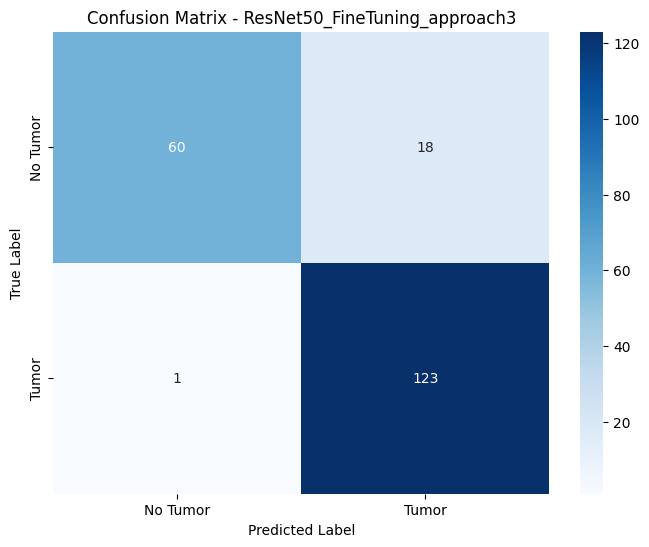

Confusion matrix saved to: results/figures/ResNet50_FineTuning_approach3_20250722_014034/confusion_matrix.png


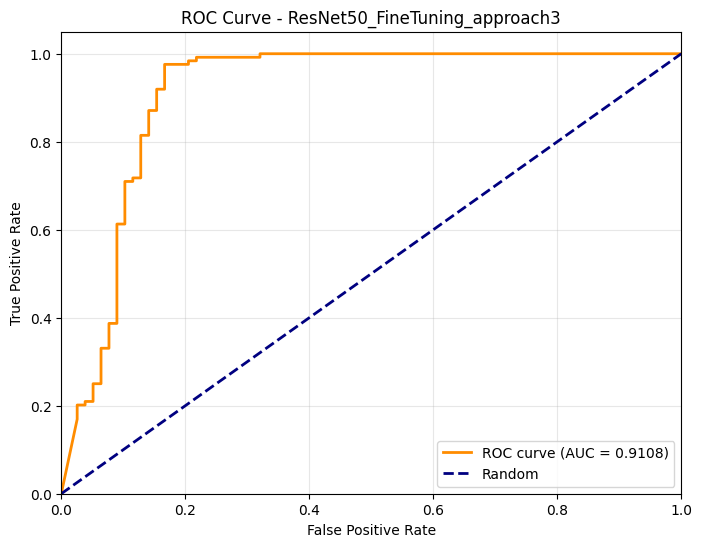

ROC curve saved to: results/figures/ResNet50_FineTuning_approach3_20250722_014034/roc_curve.png

Input data saved to: results/figures/ResNet50_FineTuning_approach3_20250722_014034/input_data.json

==== Training EfficientNetB0_FeatureExtraction with Approach 3 data-centric methods ====

Testing model EfficientNetB0_FeatureExtraction with Approach 3 data-centric methods
Using device: cuda
Using model: EfficientNetB0_FeatureExtraction
Starting 3-fold cross-validation
Class distribution:
  Class 0: 78 samples (38.6%)
  Class 1: 124 samples (61.4%)
Imbalance ratio: 1.59

FOLD 1/3

--- Training Fold 1 ---
Epoch  1/25 | Train Loss: 0.1452 | Train Acc: 64.93% | Val Loss: 0.2635 | Val Acc: 47.06% | Time: 2.2s
Epoch  2/25 | Train Loss: 0.1248 | Train Acc: 75.37% | Val Loss: 0.2002 | Val Acc: 63.24% | Time: 1.6s
Epoch  3/25 | Train Loss: 0.1158 | Train Acc: 76.87% | Val Loss: 0.2130 | Val Acc: 61.76% | Time: 1.7s
Epoch  4/25 | Train Loss: 0.1072 | Train Acc: 82.84% | Val Loss: 0.1444 | Val Acc: 7

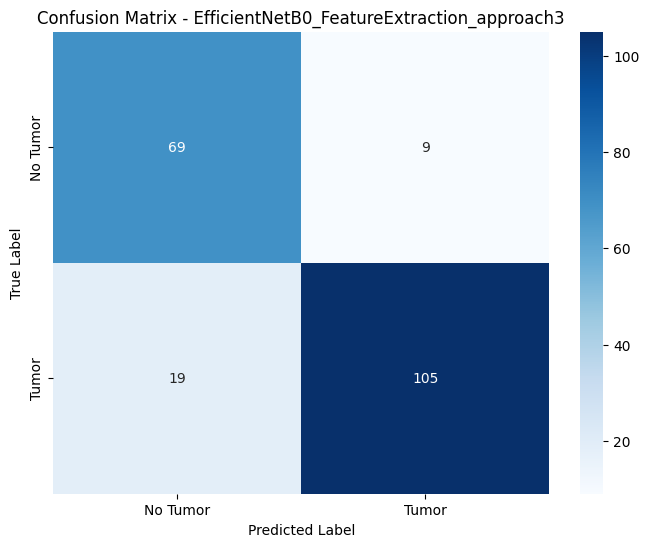

Confusion matrix saved to: results/figures/EfficientNetB0_FeatureExtraction_approach3_20250722_014217/confusion_matrix.png


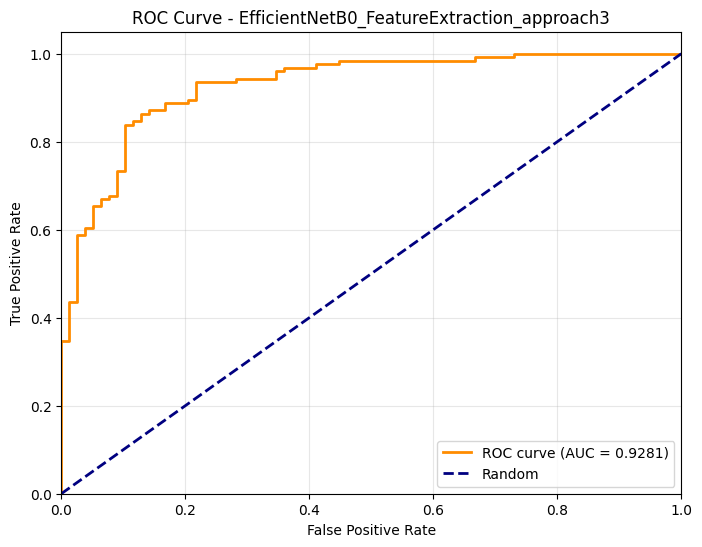

ROC curve saved to: results/figures/EfficientNetB0_FeatureExtraction_approach3_20250722_014217/roc_curve.png

Input data saved to: results/figures/EfficientNetB0_FeatureExtraction_approach3_20250722_014217/input_data.json

==== Training EfficientNetB0_FineTuning with Approach 3 data-centric methods ====

Testing model EfficientNetB0_FineTuning with Approach 3 data-centric methods
Using device: cuda
Using model: EfficientNetB0_FineTuning
Starting 3-fold cross-validation
Class distribution:
  Class 0: 78 samples (38.6%)
  Class 1: 124 samples (61.4%)
Imbalance ratio: 1.59

FOLD 1/3

--- Training Fold 1 ---
Epoch  1/25 | Train Loss: 0.1250 | Train Acc: 75.37% | Val Loss: 0.7889 | Val Acc: 48.53% | Time: 2.3s
Epoch  2/25 | Train Loss: 0.1411 | Train Acc: 83.58% | Val Loss: 0.1274 | Val Acc: 85.29% | Time: 2.0s
Epoch  3/25 | Train Loss: 0.0715 | Train Acc: 87.31% | Val Loss: 0.1399 | Val Acc: 91.18% | Time: 1.9s
Epoch  4/25 | Train Loss: 0.0565 | Train Acc: 94.03% | Val Loss: 0.1552 | Val A

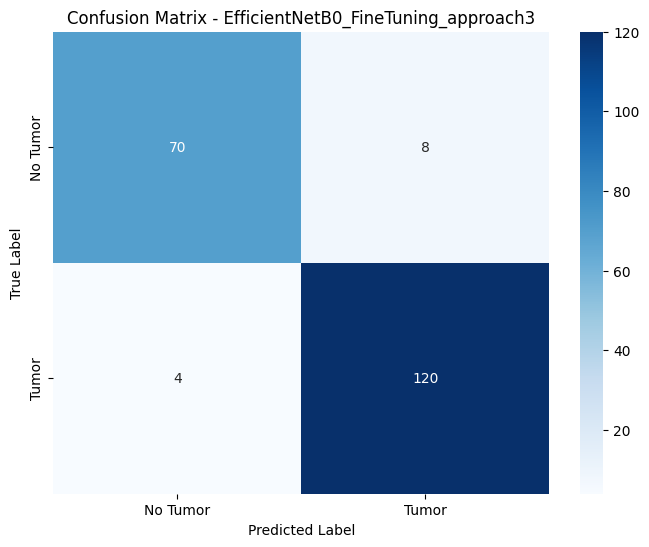

Confusion matrix saved to: results/figures/EfficientNetB0_FineTuning_approach3_20250722_014424/confusion_matrix.png


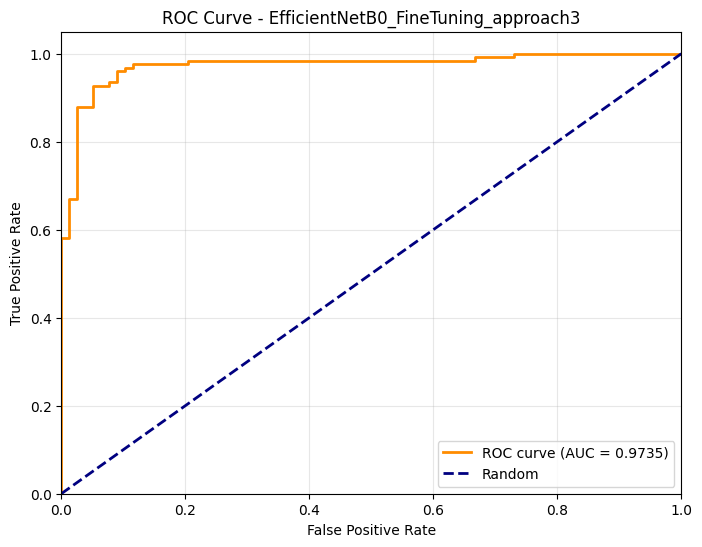

ROC curve saved to: results/figures/EfficientNetB0_FineTuning_approach3_20250722_014424/roc_curve.png

Input data saved to: results/figures/EfficientNetB0_FineTuning_approach3_20250722_014424/input_data.json

==== Training CustomCNN_Approach1 with Approach 3 data-centric methods ====

Testing model CustomCNN_Approach1 with Approach 3 data-centric methods
Using device: cuda
Using model: CustomCNN_Approach1
Starting 3-fold cross-validation
Class distribution:
  Class 0: 78 samples (38.6%)
  Class 1: 124 samples (61.4%)
Imbalance ratio: 1.59

FOLD 1/3

--- Training Fold 1 ---
Epoch  1/25 | Train Loss: 0.2485 | Train Acc: 53.73% | Val Loss: 0.1805 | Val Acc: 39.71% | Time: 2.6s
Epoch  2/25 | Train Loss: 0.2533 | Train Acc: 55.22% | Val Loss: 0.2005 | Val Acc: 61.76% | Time: 2.0s
Epoch  3/25 | Train Loss: 0.2051 | Train Acc: 60.45% | Val Loss: 1.0400 | Val Acc: 61.76% | Time: 2.0s
Epoch  4/25 | Train Loss: 0.2499 | Train Acc: 54.48% | Val Loss: 0.1786 | Val Acc: 55.88% | Time: 2.0s
Epoch  5

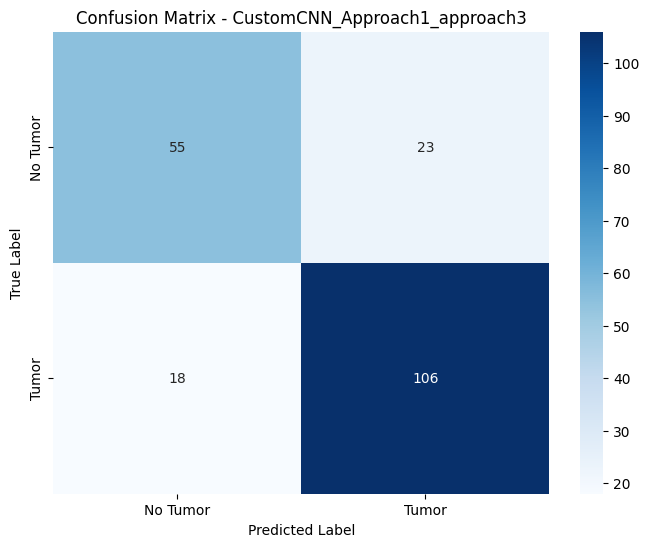

Confusion matrix saved to: results/figures/CustomCNN_Approach1_approach3_20250722_014641/confusion_matrix.png


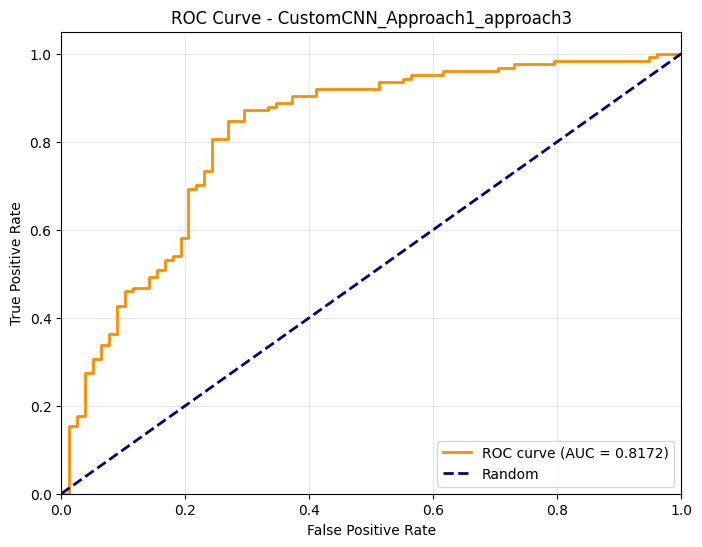

ROC curve saved to: results/figures/CustomCNN_Approach1_approach3_20250722_014641/roc_curve.png

Input data saved to: results/figures/CustomCNN_Approach1_approach3_20250722_014641/input_data.json
                              Model  Original_Accuracy  Approach3_Accuracy  \
0           VGG16_FeatureExtraction           0.803922            0.846535   
1                  VGG16_FineTuning           0.627451            0.806931   
2        ResNet50_FeatureExtraction           0.901961            0.871287   
3               ResNet50_FineTuning           0.843137            0.905941   
4  EfficientNetB0_FeatureExtraction           0.843137            0.861386   
5         EfficientNetB0_FineTuning           0.921569            0.940594   
6               CustomCNN_Approach1           0.764706            0.797030   

   Original_AUC  Approach3_AUC  
0      0.870968       0.921009  
1      0.775806       0.791356  
2      0.912097       0.911600  
3      0.911290       0.910773  
4      0.92096

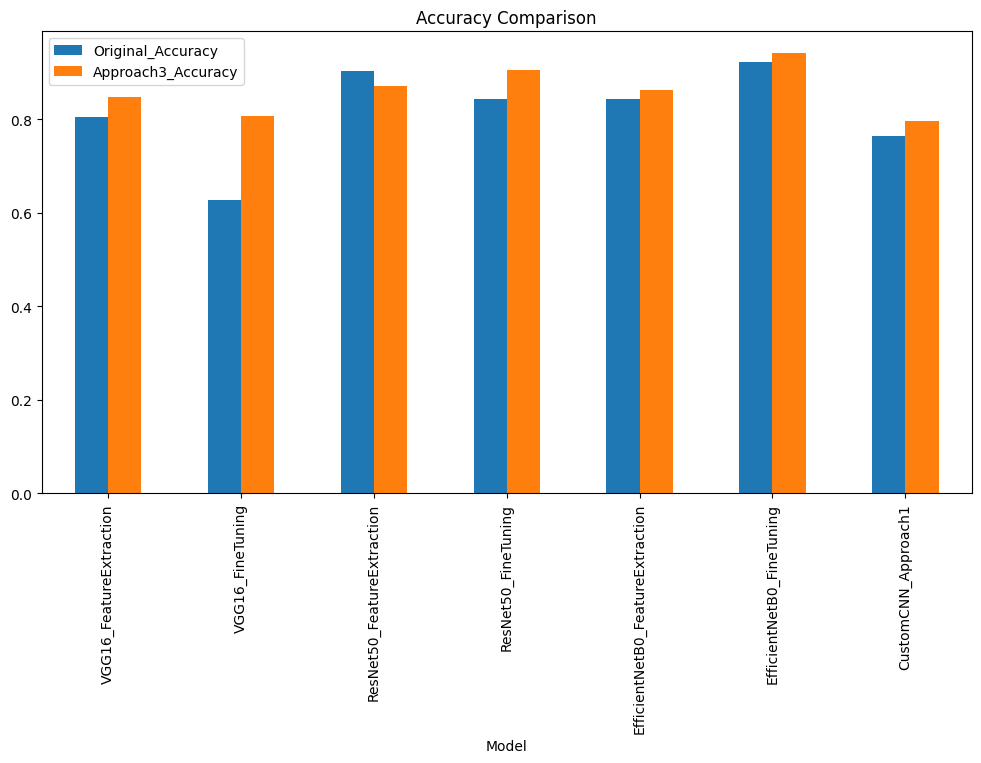

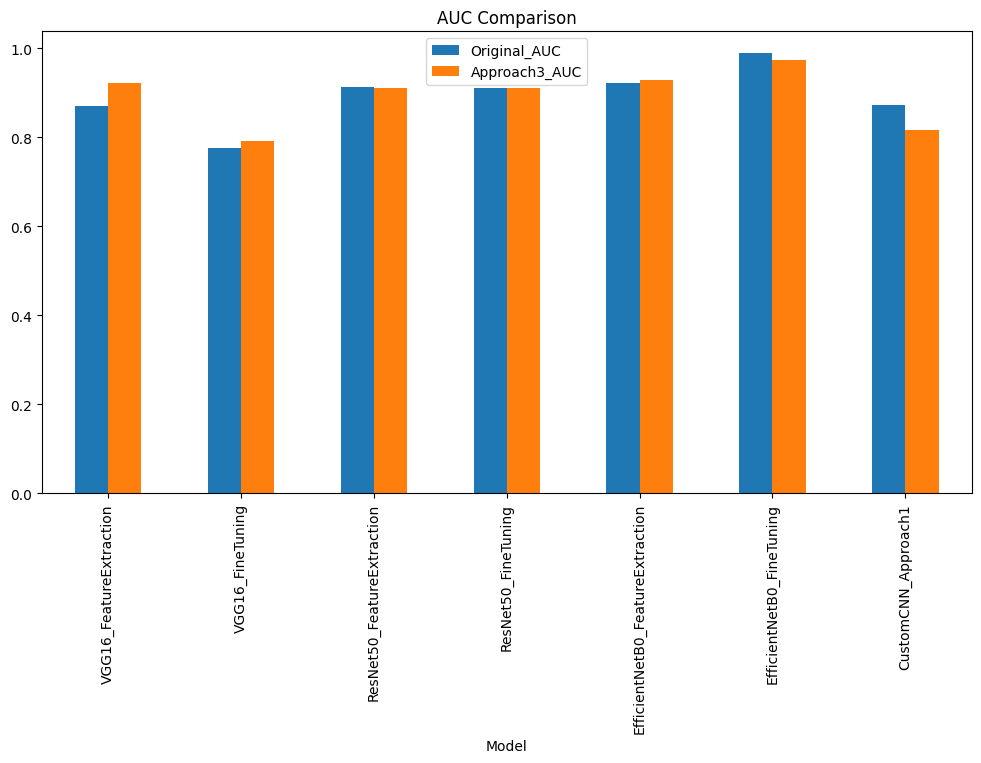

In [6]:
# =========================================
# 1. Environment Setup
# =========================================
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================
# 2. Dataset Download and Preprocessing
# =========================================

# Download and organize data
# dataloaders: dict of DataLoader, class_weights: tensor, image_datasets: dict of ImageFolder
# train_dataset and test_dataset are ImageFolder objects
# You can use train_dataset and test_dataset directly for custom DataLoader
# If you want to use Approach 3's data-centric methods, use train_dataset
# If you want to use the original pipeline, use train_dataset and test_dataset as below

dataloaders, class_weights, image_datasets = DataUtils.load_brain_tumor_data_pipeline(target_path='./data/brain_tumor_split')
train_dataset = image_datasets['train']
test_dataset = image_datasets['test']

# =========================================
# 3. Import All Model Classes
# =========================================

model_classes = [
    VGG16_FeatureExtraction,
    VGG16_FineTuning,
    ResNet50_FeatureExtraction,
    ResNet50_FineTuning,
    EfficientNetB0_FeatureExtraction,
    EfficientNetB0_FineTuning,
    CustomCNN_Approach1
]

model_names = [
    "VGG16_FeatureExtraction",
    "VGG16_FineTuning",
    "ResNet50_FeatureExtraction",
    "ResNet50_FineTuning",
    "EfficientNetB0_FeatureExtraction",
    "EfficientNetB0_FineTuning",
    "CustomCNN_Approach1"
]

# =========================================
# 4. Define Training and Evaluation Utility Functions
# =========================================


def train_and_evaluate_original(model_class, train_dataset, test_dataset, config):
    """
    Train and evaluate the model using the original data pipeline
    """
    # 1. Data augmentation (original pipeline, usually only simple transforms)
    from torchvision import transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    train_dataset.transform = transform
    test_dataset.transform = transform

    # 2. DataLoader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    # 3. Model
    model = model_class(**config['model_params']).to('cuda' if torch.cuda.is_available() else 'cpu')

    # 4. Loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

    # 5. Training
    for epoch in range(config['epochs']):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # 6. Testing
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    return all_labels, all_preds, all_probs

# =========================================
# 5. Training and Evaluation with Original Data Pipeline
# =========================================
original_results = {}
config = create_approach3_config()
for model_class, model_name in zip(model_classes, model_names):
    print(f"\n==== Training {model_name} on original data ====")
    y_true, y_pred, y_probs = train_and_evaluate_original(model_class, train_dataset, test_dataset, config)
    metrics = evaluate_model(y_true, y_pred, y_probs, model_name + "_original")
    original_results[model_name] = metrics

# =========================================
# 6. Training and Evaluation with Approach 3 Data-Centric Methods
# =========================================
approach3_results = {}
for model_class, model_name in zip(model_classes, model_names):
    print(f"\n==== Training {model_name} with Approach 3 data-centric methods ====")
    results = test_model_with_approach3_methods(model_class, train_dataset, config)
    # Use the predictions from the last fold (or customize as needed)
    y_true = results['targets']
    y_pred = np.array(results['predictions'])
    y_probs = np.array(results['probabilities'])
    metrics = evaluate_model(y_true, y_pred, y_probs, model_name + "_approach3")
    approach3_results[model_name] = metrics

# =========================================
# 7. Results Comparison and Visualization
# =========================================
import pandas as pd

summary = []
for model_name in model_names:
    orig = original_results[model_name]
    appr = approach3_results[model_name]
    summary.append({
        'Model': model_name,
        'Original_Accuracy': orig['accuracy'],
        'Approach3_Accuracy': appr['accuracy'],
        'Original_AUC': orig['auc'],
        'Approach3_AUC': appr['auc']
    })

df = pd.DataFrame(summary)
print(df)

df.plot(x='Model', y=['Original_Accuracy', 'Approach3_Accuracy'], kind='bar', figsize=(12,6), title='Accuracy Comparison')
plt.show()
df.plot(x='Model', y=['Original_AUC', 'Approach3_AUC'], kind='bar', figsize=(12,6), title='AUC Comparison')
plt.show()